In [6]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM
import matplotlib.pyplot as plt
from cvxopt import matrix, solvers
from concurrent.futures import ThreadPoolExecutor

In [7]:
df = pd.read_csv('Datasets/predict-dropout-or-academic-success.csv')

In [8]:
df.head()

,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,15,1,9254,1,1,160.0,1,1,3,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,9070,1,1,122.0,1,37,37,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,17,2,9773,1,1,122.0,1,38,37,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,39,1,8014,0,1,100.0,1,37,38,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate


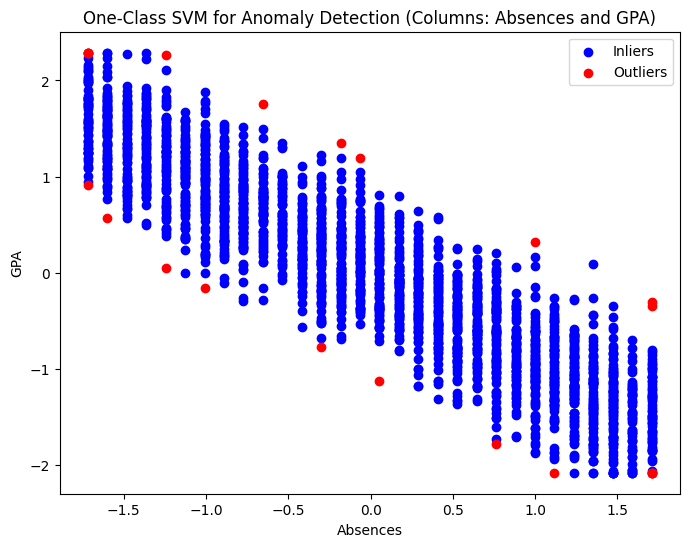

In [5]:
x_column = 'Absences'
y_column = 'GPA'

# Extract the selected columns
data = df[[x_column, y_column]]

# Standardise the data
scaler = StandardScaler()
data_norm = scaler.fit_transform(data)

model = OneClassSVM(nu=0.01, kernel="rbf", gamma=0.7)
model.fit(data_norm)

# Predict anomalies, outliers = -1
y_pred = model.predict(data_norm)

plt.figure(figsize=(8, 6))

# Inliers
plt.scatter(data_norm[y_pred == 1, 0], data_norm[y_pred == 1, 1], color='blue', label='Inliers')

# Outliers
plt.scatter(data_norm[y_pred == -1, 0], data_norm[y_pred == -1, 1], color='red', label='Outliers')

plt.title(f"One-Class SVM for Anomaly Detection (Columns: {x_column} and {y_column})")
plt.xlabel(x_column)
plt.ylabel(y_column)
plt.legend()
plt.show()


In [6]:
cols = ['Absences','GPA']
num_data = df[cols]

# Standardise the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(num_data)

# Apply One-Class SVM
svm_model = OneClassSVM(kernel='rbf', gamma=0.7, nu=0.01)
svm_labels = svm_model.fit_predict(scaled_data)

# Add SVM labels to the original data
df['svm_label'] = svm_labels

# Filter rows considered anomalous
anomalous_data = df[df['svm_label'] == -1]

# Display the anomalous rows
print(anomalous_data)

      StudentID  Age  Gender  Ethnicity  ParentalEducation  StudyTimeWeekly  \
115        1116   18       1          0                  3         1.559877   
442        1443   15       0          0                  2        19.424398   
474        1475   17       1          1                  2         1.444587   
484        1485   15       1          0                  3         0.767231   
538        1539   15       1          1                  2         1.447528   
591        1592   18       0          2                  2         7.560499   
947        1948   18       0          1                  1        13.098822   
1105       2106   18       0          2                  2        19.520403   
1249       2250   18       0          3                  1         6.185362   
1303       2304   16       0          0                  1        19.124423   
1327       2328   15       1          0                  1        19.444594   
1500       2501   17       1          1             

In [ ]:
class OCSVM:
    def __init__(self, nu=0.1, kernel='rbf', gamma=1.0):
        self.nu = nu
        self.kernel = kernel
        self.gamma = gamma

    def _kernel_function(self, X, Y=None):
        # Computer the kernel matrix
        if Y is None:
            Y = X
        if self.kernel == 'rbf':
            # Approximate RBF kernel using Random Fourier Features
            n_features = 100  # Dimensionality of approximation
            rng = np.random.default_rng(seed=42)
            omega = rng.normal(0, np.sqrt(2 * self.gamma), size=(X.shape[1], n_features))
            b = rng.uniform(0, 2 * np.pi, size=n_features)
            X_proj = np.cos(X @ omega + b)
            Y_proj = np.cos(Y @ omega + b) if Y is not X else X_proj
            return X_proj @ Y_proj.T
        elif self.kernel == 'linear':
            # Linear kernel
            return np.dot(X, Y.T)
        elif self.kernel == 'poly':
            # Polynomial kernel
            return (np.dot(X, Y.T) + 1) ** 3
        else:
            raise ValueError("Unsupported kernel type")

    def fit(self, X):
        n_samples = X.shape[0]
        K = self._kernel_function(X)

        # Define the quadratic programming problem
        P = matrix(K)
        q = matrix(-np.ones((n_samples, 1)))
        
        G = matrix(np.vstack((-np.eye(n_samples), np.eye(n_samples))))
        h = matrix(np.hstack((np.zeros(n_samples), np.ones(n_samples) / (self.nu * n_samples))))
        
        A = matrix(1.0, (1, n_samples)) # Equaltiy constraint
        b = matrix(1.0)

        # Solve quadratic programming problem
        sol = solvers.qp(P, q, G, h, A, b)

        # Extract Lagrange multipliers (alphas)
        alphas = np.array(sol['x']).flatten()
        support_vector_indices = alphas > 1e-5
        self.alphas = alphas[support_vector_indices]
        self.support_vectors = X[support_vector_indices]
        self.K_sv = K[support_vector_indices][:, support_vector_indices]
        
        # Compute the intercept term
        self.rho = np.mean(self.K_sv @ self.alphas)

    def decision_function(self, X):
        # Compute the decision function
        K_test = self._kernel_function(X, self.support_vectors)
        return np.sum(K_test * self.alphas, axis=1) - self.rho

    def predict(self, X):
        # Predict whether the data is an inlier or an outlier
        return np.sign(self.decision_function(X))
    
    
    def plot(self, X):
        predictions = self.predict(X)
        inliers = X[predictions == 1]
        outliers = X[predictions == -1]

        # Print IDs of outliers
        outlier_ids = np.where(predictions == -1)[0]
        print("Outlier IDs:", outlier_ids)

        plt.figure(figsize=(8, 6))
        plt.scatter(inliers[:, 0], inliers[:, 1], c='blue', label='Inliers', s=20)
        plt.scatter(outliers[:, 0], outliers[:, 1], c='red', label='Outliers', s=20)
        plt.title('One-Class SVM Results')
        plt.xlabel('Feature 1')
        plt.ylabel('Feature 2')
        plt.legend()
        plt.grid(True)
        plt.show()

In [11]:
data = df[['Previous qualification (grade)', 'Admission grade']]
data_norm = StandardScaler().fit_transform(data)

# Train custom One-Class SVM
oc_svm = OCSVM(nu=0.01, kernel='rbf', gamma=1)
oc_svm.fit(data_norm)
oc_svm.plot(data_norm)

# Predict on training data_norm
predictions = oc_svm.predict(data_norm)
print("Predictions:", predictions)


     pcost       dcost       gap    pres   dres
 0: -9.7023e-01 -1.0107e+02  9e+03  6e+01  2e-16
 1: -9.6656e-01 -9.6821e+01  2e+02  6e-01  3e-16
 2: -9.4112e-01 -1.1963e+01  1e+01  4e-03  5e-16
 3: -9.3902e-01 -2.0735e+00  1e+00  4e-04  7e-16
 4: -9.1324e-01 -1.8342e+00  9e-01  2e-04  4e-16
 5: -9.2084e-01 -1.6660e+00  7e-01  5e-05  2e-16
 6: -9.4430e-01 -1.1760e+00  2e-01  1e-05  3e-16
 7: -9.4696e-01 -1.1685e+00  2e-01  1e-05  2e-16
 8: -9.5985e-01 -1.0853e+00  1e-01  1e-06  1e-16
 9: -9.6587e-01 -1.0280e+00  6e-02  8e-08  1e-16
10: -9.6890e-01 -1.0048e+00  4e-02  4e-08  8e-17
11: -9.7119e-01 -9.8241e-01  1e-02  5e-09  7e-17
12: -9.7170e-01 -9.7853e-01  7e-03  1e-09  7e-17
13: -9.7208e-01 -9.7400e-01  2e-03  4e-11  7e-17
14: -9.7211e-01 -9.7376e-01  2e-03  3e-11  5e-17
15: -9.7220e-01 -9.7264e-01  4e-04  5e-12  5e-17
16: -9.7221e-01 -9.7254e-01  3e-04  2e-12  5e-17
17: -9.7223e-01 -9.7240e-01  2e-04  1e-12  6e-17
18: -9.7224e-01 -9.7232e-01  8e-05  3e-13  5e-17
19: -9.7224e-01 -9.72

TypeError: unsupported operand type(s) for *: 'NoneType' and 'float'